In [73]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Feature extraction
from sklearn.feature_extraction.text import TfidfVectorizer

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler


# Machine learning models
from sklearn.naive_bayes import MultinomialNB

# Sentiment analysis
from textblob import TextBlob

# Parallel processing
from joblib import Parallel, delayed
import multiprocessing

from scipy.sparse import hstack
from scipy import sparse

# Saving and loading models and data
import pickle
import os

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# NLTK downloads
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
train_full = pd.read_csv('train.csv')
test_full = pd.read_csv('test.csv')

print(f"Full training data shape: {train_full.shape}")
print(f"Test data shape: {test_full.shape}")

# Remove rows with missing 'Score' in the full training data
train_full_notna = train_full.dropna(subset=['Score']).reset_index(drop=True)

print(f"Full training data shape after removing missing 'Score': {train_full_notna.shape}")

# Sample 10,000 reviews from the filtered training data
train = train_full_notna.sample(n=10000, random_state=42).reset_index(drop=True)

print(f"Sampled training data shape: {train.shape}")



Full training data shape: (1697533, 9)
Test data shape: (212192, 2)
Full training data shape after removing missing 'Score': (1485341, 9)
Sampled training data shape: (10000, 9)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Id                      10000 non-null  int64  
 1   ProductId               10000 non-null  object 
 2   UserId                  10000 non-null  object 
 3   HelpfulnessNumerator    10000 non-null  int64  
 4   HelpfulnessDenominator  10000 non-null  int64  
 5   Time                    10000 non-null  int64  
 6   Summary                 9999 non-null   object 
 7   Text                    9999 non-null   object 
 8   Score                   10000 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 703.2+ KB


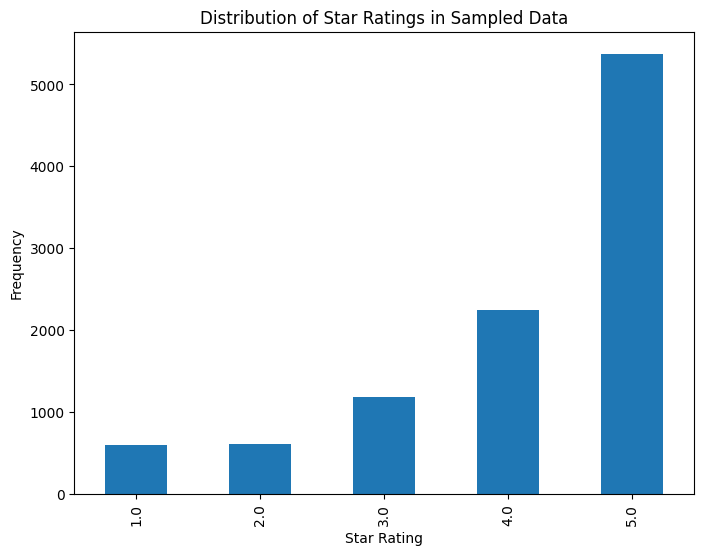

In [75]:
# Display first few rows of the sampled training set
train.head()
# Information about the sampled training data
train.info()
# Statistical summary of numerical features
train.describe()
# Distribution of the target variable 'Score'
train['Score'].value_counts().sort_index().plot(kind='bar', figsize=(8,6))
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Star Ratings in Sampled Data')
plt.show()



In [76]:
if os.path.exists('train_sample_processed.pkl'):
    print("Loading preprocessed sampled training data...")
    with open('train_sample_processed.pkl', 'rb') as file:
        train = pickle.load(file)
else:
    print("Preprocessing sampled training data...")
    # Fill missing values in 'HelpfulnessNumerator' and 'HelpfulnessDenominator' with 0
    train['HelpfulnessNumerator'] = train['HelpfulnessNumerator'].fillna(0)
    train['HelpfulnessDenominator'] = train['HelpfulnessDenominator'].fillna(0)

    # Drop rows where 'Summary' or 'Text' is missing
    train = train.dropna(subset=['Summary', 'Text'])

    # Create 'HelpfulnessRatio' feature
    train['HelpfulnessRatio'] = train['HelpfulnessNumerator'] / train['HelpfulnessDenominator']
    train['HelpfulnessRatio'] = train['HelpfulnessRatio'].replace([np.inf, -np.inf], 0)
    train['HelpfulnessRatio'] = train['HelpfulnessRatio'].fillna(0)

    # Calculate lengths of 'Summary' and 'Text'
    train['SummaryLength'] = train['Summary'].apply(len)
    train['TextLength'] = train['Text'].apply(len)

    # Convert 'Time' to datetime and extract components
    train['ReviewTime'] = pd.to_datetime(train['Time'], unit='s')
    train['ReviewYear'] = train['ReviewTime'].dt.year
    train['ReviewMonth'] = train['ReviewTime'].dt.month
    train['ReviewDay'] = train['ReviewTime'].dt.day

    # Function to calculate sentiment polarity
    def get_sentiment(text):
        return TextBlob(text).sentiment.polarity

    # Since sentiment analysis is time-consuming, we can use parallel processing
    num_cores = multiprocessing.cpu_count()

    # Calculate sentiment scores in parallel
    train['SummarySentiment'] = Parallel(n_jobs=num_cores)(
        delayed(get_sentiment)(text) for text in train['Summary']
    )
    train['TextSentiment'] = Parallel(n_jobs=num_cores)(
        delayed(get_sentiment)(text) for text in train['Text']
    )

    # Save the processed DataFrame
    with open('train_sample_processed.pkl', 'wb') as file:
        pickle.dump(train, file)
    print("Sampled training data preprocessed and saved.")


Loading preprocessed sampled training data...


In [77]:
if os.path.exists('cleaned_text_sample.pkl'):
    print("Loading cleaned text data for sampled training data...")
    with open('cleaned_text_sample.pkl', 'rb') as file:
        cleaned_summary, cleaned_text = pickle.load(file)
    train['CleanedSummary'] = cleaned_summary
    train['CleanedText'] = cleaned_text
else:
    print("Cleaning text data for sampled training data...")
    # Initialize PorterStemmer and compile regex
    ps = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    regex = re.compile('[^a-zA-Z]')

    # Function to clean text
    def clean_text(text):
        text = text.lower()
        text = regex.sub(' ', text)
        words = text.split()
        words = [ps.stem(word) for word in words if word not in stop_words]
        return ' '.join(words)

    # Clean 'Summary' and 'Text' in parallel
    num_cores = multiprocessing.cpu_count()
    train['CleanedSummary'] = Parallel(n_jobs=num_cores)(
        delayed(clean_text)(text) for text in train['Summary']
    )
    train['CleanedText'] = Parallel(n_jobs=num_cores)(
        delayed(clean_text)(text) for text in train['Text']
    )

    # Save the cleaned text data
    with open('cleaned_text_sample.pkl', 'wb') as file:
        pickle.dump((train['CleanedSummary'], train['CleanedText']), file)
    print("Cleaned text data for sampled training data saved.")


Loading cleaned text data for sampled training data...


In [78]:
if os.path.exists('tfidf_features_sample.pkl') and os.path.exists('tfidf_vectorizer_sample.pkl'):
    print("Loading TF-IDF features and vectorizer for sampled training data...")
    with open('tfidf_features_sample.pkl', 'rb') as file:
        X_text = pickle.load(file)
    with open('tfidf_vectorizer_sample.pkl', 'rb') as file:
        tfidf_vectorizer = pickle.load(file)
else:
    print("Extracting TF-IDF features for sampled training data...")
    # Combine 'CleanedSummary' and 'CleanedText'
    train['CombinedText'] = train['CleanedSummary'] + ' ' + train['CleanedText']

    # Initialize TF-IDF Vectorizer
    tfidf_vectorizer = TfidfVectorizer(max_features=5000)

    # Fit and transform the combined text
    X_text = tfidf_vectorizer.fit_transform(train['CombinedText'])
    X_text = X_text.toarray()  # Convert to array if necessary

    # Save the TF-IDF features and vectorizer
    with open('tfidf_features_sample.pkl', 'wb') as file:
        pickle.dump(X_text, file)
    with open('tfidf_vectorizer_sample.pkl', 'wb') as file:
        pickle.dump(tfidf_vectorizer, file)
    print("TF-IDF features for sampled training data extracted and saved.")


Loading TF-IDF features and vectorizer for sampled training data...


In [79]:
# List of numerical features to include
numerical_features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio',
                      'SummaryLength', 'TextLength', 'SummarySentiment', 'TextSentiment',
                      'ReviewYear', 'ReviewMonth', 'ReviewDay']

# Extract numerical features
X_numeric = train[numerical_features].values

scaler = MinMaxScaler()

# Fit and transform numerical features
X_numeric_scaled = scaler.fit_transform(X_numeric)

# Save the scaler for later use
with open('scaler_sample.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Combine scaled numerical features with text features
X = np.hstack((X_numeric_scaled, X_text))

# Extract target variable
y = train['Score'].values
print(f"Number of missing values in 'y': {np.isnan(y).sum()}")


Number of missing values in 'y': 0


In [80]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
print("Class Weights:", class_weight_dict)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Initialize Multinomial Naive Bayes model
nb_model = MultinomialNB()
# Define parameter grid for GridSearchCV
param_grid = {'alpha': [0.1, 0.5, 1.0]}

# Initialize GridSearchCV with parallel processing
grid_search = GridSearchCV(nb_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and estimator
print(f"Best Parameters: {grid_search.best_params_}")
nb_model = grid_search.best_estimator_

# Save the trained model
with open('nb_model_sample.pkl', 'wb') as file:
    pickle.dump(nb_model, file)


Class Weights: {1.0: 3.3271214642262894, 2.0: 3.2942339373970344, 3.0: 1.7003401360544217, 4.0: 0.8930772666368915, 5.0: 0.37201860465116277}
Best Parameters: {'alpha': 0.1}


Validation Accuracy: 0.566
Classification Report:
              precision    recall  f1-score   support

         1.0       0.74      0.22      0.34       120
         2.0       0.50      0.02      0.05       122
         3.0       0.41      0.11      0.17       235
         4.0       0.33      0.20      0.25       448
         5.0       0.61      0.92      0.73      1075

    accuracy                           0.57      2000
   macro avg       0.52      0.29      0.31      2000
weighted avg       0.52      0.57      0.49      2000



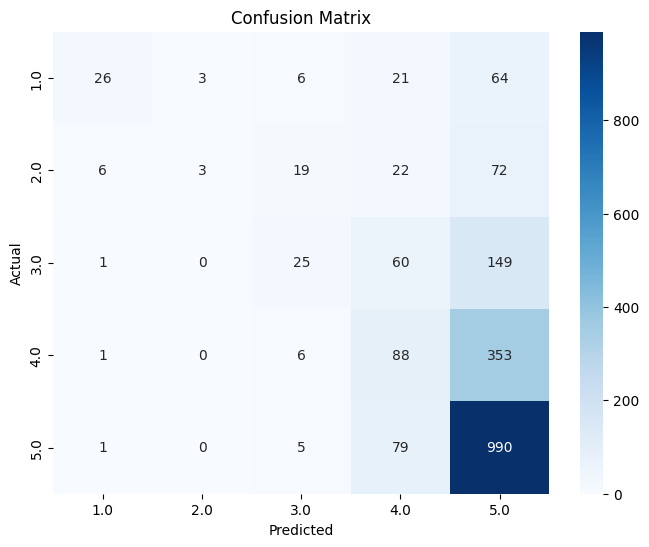

In [81]:
# Predict on validation set
y_pred = nb_model.predict(X_val)
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy}")
# Classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

test = test_full[['Id']].merge(train_full, on='Id', how='left')


In [83]:
# Ensure that the required columns exist
required_columns = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Summary', 'Text', 'Time']

missing_columns = [col for col in required_columns if col not in test.columns]
if missing_columns:
    print(f"The following columns are missing in the test set: {missing_columns}")
    # Handle missing columns appropriately (e.g., raise an error or handle as needed)
else:
    print("All required columns are present in the test set.")
# Fill missing values in 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
test['HelpfulnessNumerator'] = test['HelpfulnessNumerator'].fillna(0)
test['HelpfulnessDenominator'] = test['HelpfulnessDenominator'].fillna(0)

test['Summary'] = test['Summary'].fillna('')
test['Text'] = test['Text'].fillna('')

# Create 'HelpfulnessRatio'
test['HelpfulnessRatio'] = test['HelpfulnessNumerator'] / test['HelpfulnessDenominator']
test['HelpfulnessRatio'] = test['HelpfulnessRatio'].replace([np.inf, -np.inf], 0)
test['HelpfulnessRatio'] = test['HelpfulnessRatio'].fillna(0)

# Calculate lengths of 'Summary' and 'Text'
test['SummaryLength'] = test['Summary'].apply(len)
test['TextLength'] = test['Text'].apply(len)

# Convert 'Time' to datetime and extract components
test['ReviewTime'] = pd.to_datetime(test['Time'], unit='s')
test['ReviewYear'] = test['ReviewTime'].dt.year
test['ReviewMonth'] = test['ReviewTime'].dt.month
test['ReviewDay'] = test['ReviewTime'].dt.day

# Function to calculate sentiment polarity (ensure it's defined)
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Calculate sentiment scores
num_cores = multiprocessing.cpu_count()
test['SummarySentiment'] = Parallel(n_jobs=num_cores)(
    delayed(get_sentiment)(text) for text in test['Summary']
)
test['TextSentiment'] = Parallel(n_jobs=num_cores)(
    delayed(get_sentiment)(text) for text in test['Text']
)

# Clean text data (ensure 'clean_text' function is defined)
test['CleanedSummary'] = Parallel(n_jobs=num_cores)(
    delayed(clean_text)(text) for text in test['Summary']
)
test['CleanedText'] = Parallel(n_jobs=num_cores)(
    delayed(clean_text)(text) for text in test['Text']
)

# Combine cleaned text
test['CombinedText'] = test['CleanedSummary'] + ' ' + test['CleanedText']
# List of numerical features to include
numerical_features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'HelpfulnessRatio',
    'SummaryLength', 'TextLength', 'SummarySentiment', 'TextSentiment',
    'ReviewYear', 'ReviewMonth', 'ReviewDay'
]

# Extract numerical features
X_test_numeric = test[numerical_features].values

# Load the scaler and transform numerical features
with open('scaler_sample.pkl', 'rb') as file:
    scaler = pickle.load(file)
X_test_numeric_scaled = scaler.transform(X_test_numeric)

# Load the TF-IDF vectorizer and transform text data
with open('tfidf_vectorizer_sample.pkl', 'rb') as file:
    tfidf_vectorizer = pickle.load(file)
X_test_text = tfidf_vectorizer.transform(test['CombinedText'])

# Combine numerical and text features
X_test_numeric_scaled_sparse = sparse.csr_matrix(X_test_numeric_scaled)
X_test = hstack((X_test_numeric_scaled_sparse, X_test_text))


All required columns are present in the test set.


In [84]:
# Load the trained model
with open('nb_model_sample.pkl', 'rb') as file:
    nb_model = pickle.load(file)

# Predict on test set
test_predictions = nb_model.predict(X_test)
# Prepare submission dataframe
submission = pd.DataFrame({'Id': test['Id'], 'Score': test_predictions})

# Save to CSV
submission.to_csv('submission_sample.csv', index=False)

# Display first few rows of the submission file
submission.head()


,Id,Score
0,1323432,5.0
1,1137299,5.0
2,1459366,5.0
3,931601,5.0
4,1311995,5.0
